# RNN implementation

## Data Preprocessing 

In [3]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}
print(stoi, itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# 1. Define a device variable. If a GPU is available, use it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available CUDA devices
    num_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_devices)

    # Get information about the current device
    current_device_id = torch.cuda.current_device()
    print("Current device ID:", current_device_id)

    # Get the name of the current device
    device_name = torch.cuda.get_device_name(current_device_id)
    print("Device name:", device_name)

    # Get detailed device properties
    device_props = torch.cuda.get_device_properties(current_device_id)
    print("Device properties:", device_props)

    # Get memory information
    memory_allocated = torch.cuda.memory_allocated(current_device_id)
    memory_reserved = torch.cuda.memory_reserved(current_device_id)
    print("Memory allocated:", memory_allocated)
    print("Memory reserved:", memory_reserved)
else:
    print("CUDA is not available.")

Using device: cuda
Number of CUDA devices: 1
Current device ID: 0
Device name: Quadro P5000
Device properties: _CudaDeviceProperties(name='Quadro P5000', major=6, minor=1, total_memory=16272MB, multi_processor_count=20)
Memory allocated: 0
Memory reserved: 0


## Hyperparameters

In [5]:
runs = {}

In [132]:
for i, v in runs.items():
    print(f"{i} \n eval_loss: {v['eval_loss'].item():.4f}, train_loss: {v['train_loss'].item():.4f},  train_time: {v['time']:.2f}s")
    
# 50k -> 1m
# 10k -> 10s

block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_10000___A 
 eval_loss: 2.4212, train_loss: 2.4113,  train_time: 10.90s
block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_1___A 
 eval_loss: 27.1962, train_loss: 27.1937,  train_time: 0.01s


In [147]:

hyperparams = {
'block_size': 3,
'embedding_size': 10,
'hidden_layer_size': 200,
'batch_size': 32,
'learning_rates_A': 0.10,
'learning_rates_B': 0.02,
'epochs': 10000
}


def hyperparams_to_run_name():
    return ''.join([f"{k}_{v}__" for k, v in hyperparams.items()]) + "_A"

hyperparams_to_run_name()

'block_size_3__embedding_size_10__hidden_layer_size_200__batch_size_32__learning_rates_A_0.1__learning_rates_B_0.02__epochs_10000___A'

## Training Data

In [148]:
import torch

block_size = hyperparams['block_size']
embedding_size = hyperparams['embedding_size']
epochs = hyperparams['epochs']
learning_rates = [0, 0]
learning_rates[0] = hyperparams['learning_rates_A']
learning_rates[1] = hyperparams['learning_rates_B']
hidden_layer_size = hyperparams['hidden_layer_size']
batch_size = hyperparams['batch_size']

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(context, ix)
            #print(''.join(itos[i] for i in context), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



## Model

In [149]:

C = torch.randn((27, embedding_size), device=device)
W1 = torch.randn((embedding_size * block_size, hidden_layer_size), device=device)
b1 = torch.randn(hidden_layer_size, device=device)
W2 = torch.randn((hidden_layer_size, 27), device=device)
b2 = torch.randn(27, device=device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

print(sum(p.nelement() for p in parameters))

lri = []
lossi = []
lossepochs = []

#logits = h @ W2 + b2
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdims=True)

#loss = -prob[torch.arange(32), Y].log().mean() 
# here the mean means we take the mean of all the losses
# of all individual training examples

#loss == F.cross_entropy(logits, Y)

#lre = torch.linspace(-3, 0, 1000)
#lrs = 10**lre`b
#lrs.shape

11897


## Training


In [129]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
print(ix.shape)
print(Xtr.shape)
x = Xtr[ix]
print(x.shape)
print(C.shape)
print(C[x].shape)
emb = C[x]
emb.view(-1,  block_size * embedding_size).shape

torch.Size([32])
torch.Size([182580, 3])
torch.Size([32, 3])
torch.Size([27, 10])
torch.Size([32, 3, 10])


torch.Size([32, 30])

2.449280261993408
2.4342870712280273


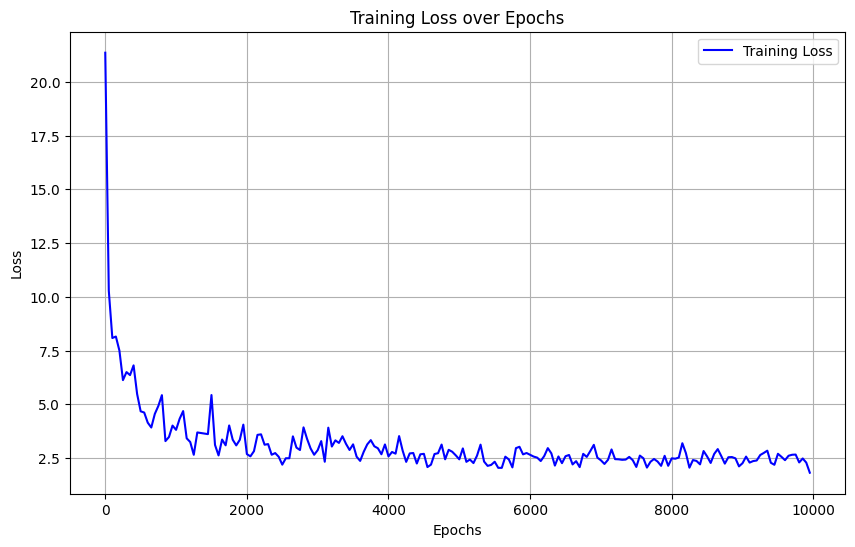

In [150]:
import torch.nn.functional as F

def train(learning_rate, epoch):
    #minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
    
    # forward pass|
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= learning_rate * p.grad
        
    if epoch % 50 == 0:
        #lri.append(lre[i].item
        lossi.append(loss.item())
        lossepochs.append(epoch)

import time
start_time = time.time()

for i in range(int(epochs/2)):
    train(learning_rates[0], i)
for i in range(int(epochs/2)):
    train(learning_rates[1], int(epochs/2)+i)
    

emb = C[Xval]
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1)
logits = h @ W2 + b2
eval_loss = F.cross_entropy(logits, Yval)
print(eval_loss.item())

emb = C[Xtr]
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr)
print(train_loss.item())

end_time = time.time()

run_name = hyperparams_to_run_name()
runs[run_name] = {'eval_loss': eval_loss, 'train_loss': train_loss, 'lossi': lossi, 'lossepochs': lossepochs, 'time': end_time - start_time }

import matplotlib.pyplot as plt

# Optionally, set the figure size for better visibility.
plt.figure(figsize=(10, 6))

# Plot the loss values versus epochs.
plt.plot(lossepochs, lossi, linestyle='-', color='blue', label='Training Loss')

# Add labels to the axes.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Add a title to the plot.
plt.title("Training Loss over Epochs")

# Add a grid for easier visualization of the values.
plt.grid(True)

# Add a legend to explain the plot elements.
plt.legend()

# Display the plot.
plt.show()


## Inference

In [151]:
@torch.no_grad()
def inference():
    sentence, end_token = [".", ".", "."], False
    while not end_token:
        context_ixs = [stoi[x] for x in sentence[-3:]]
        x_inference = torch.tensor(context_ixs, dtype=torch.int)
        emb = C[x_inference]
        final_layer = torch.tanh(emb.view(1, block_size * embedding_size) @ W1 + b1) @ W2 + b2
        probabilities = torch.exp(final_layer) / torch.sum(torch.exp(final_layer), axis=1, keepdim=True)
        next_letter = itos[torch.multinomial(probabilities, num_samples=1).item()]
        sentence.append(next_letter)
        if next_letter == '.':
            end_token = True
    print(''.join(sentence))

for _ in range(50):
    inference()

...rrynw.
...birou.
...kamis.
...annasuilo.
...cuki.
...dap.
...ratiy.
...sai.
...dabila.
...davinh.
...maria.
...harlin.
...adistiahaner.
...balhin.
...caryson.
...sarandranaldeners.
...sadan.
...chendierat.
...jolan.
...esa.
...kamian.
...eimariydan.
...brase.
...siaviklin.
...aevoryan.
...kasbe.
...neralemi.
...lal.
...ami.
...mael.
...mute.
...ainha.
...cori.
...jaelay.
...zamie.
...avannn.
...alaysiaisa.
...lid.
...dvannaellynn.
...lavee.
...maiarire.
...harsitkianariya.
...krarlalyn.
...mamirasi.
...cairy.
...diightzy.
...kaisl.
...saridirlyn.
...kor.
...ada.


# Appendix

In [40]:
torch.cat([emb[:, i, :] for i in range(block_size)], 1).shape

torch.Size([32, 6])

In [43]:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-0.1152, -1.1897, -0.1152, -1.1897, -0.1152, -1.1897],
        [-0.1152, -1.1897, -0.1152, -1.1897,  0.2716,  1.0055],
        [-0.1152, -1.1897,  0.2716,  1.0055, -0.7203, -0.5304],
        [ 0.2716,  1.0055, -0.7203, -0.5304, -0.7203, -0.5304],
        [-0.7203, -0.5304, -0.7203, -0.5304,  0.2930,  0.3207],
        [-0.1152, -1.1897, -0.1152, -1.1897, -0.1152, -1.1897],
        [-0.1152, -1.1897, -0.1152, -1.1897,  1.3084,  0.0505],
        [-0.1152, -1.1897,  1.3084,  0.0505, -0.7158,  0.4897],
        [ 1.3084,  0.0505, -0.7158,  0.4897, -1.0853,  2.4026],
        [-0.7158,  0.4897, -1.0853,  2.4026,  0.0674, -0.0325],
        [-1.0853,  2.4026,  0.0674, -0.0325, -1.0853,  2.4026],
        [ 0.0674, -0.0325, -1.0853,  2.4026,  0.2930,  0.3207],
        [-0.1152, -1.1897, -0.1152, -1.1897, -0.1152, -1.1897],
        [-0.1152, -1.1897, -0.1152, -1.1897,  0.2930,  0.3207],
        [-0.1152, -1.1897,  0.2930,  0.3207,  0.0674, -0.0325],
        [ 0.2930,  0.3207,  0.0674, -0.0

In [48]:
a = torch.arange(18)
a.shape

torch.Size([18])

In [49]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [52]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [55]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T